In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Load the dataset (MIT-BIH dataset has separate train and test files)
print("Loading training data...")
df_train = pd.read_csv('mitbih_train.csv', header=None)
print("Loading test data...")
df_test = pd.read_csv('mitbih_test.csv', header=None)

Loading training data...
Loading test data...


In [15]:
# Display dataset information
print(f"Training data shape: {df_train.shape}")
print(f"Testing data shape: {df_test.shape}")


Training data shape: (84333, 188)
Testing data shape: (21892, 188)


In [16]:
# Check for missing values
print("Missing values in training data:", df_train.isnull().sum().sum())
print("Missing values in test data:", df_test.isnull().sum().sum())

Missing values in training data: 134
Missing values in test data: 0


In [18]:
# Extract features and labels
# Last column is the class label in these datasets
X_train_raw = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test_raw = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

In [19]:
# Check class distribution
print("Class distribution in training data:")
print(pd.Series(y_train).value_counts())

Class distribution in training data:
0.0    72471
2.0     5788
4.0     3209
1.0     2223
3.0      641
Name: count, dtype: int64


In [20]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [21]:
# Normalize signals
# Normalize each signal individually by dividing by its max value
print("Normalizing signals...")
X_train_normalized = np.zeros_like(X_train_raw, dtype=float)
X_test_normalized = np.zeros_like(X_test_raw, dtype=float)


Normalizing signals...


In [22]:
for i in range(X_train_raw.shape[0]):
    max_val = np.max(np.abs(X_train_raw[i]))
    if max_val > 0:  # Avoid division by zero
        X_train_normalized[i] = X_train_raw[i] / max_val

for i in range(X_test_raw.shape[0]):
    max_val = np.max(np.abs(X_test_raw[i]))
    if max_val > 0:  # Avoid division by zero
        X_test_normalized[i] = X_test_raw[i] / max_val

In [23]:
# Extract statistical features over windows
window_size = 50  # Adjust as needed (187/50 ≈ 3-4 windows per signal)

In [24]:
def extract_features(signals, window_size):
    all_features = []
    for signal in signals:
        signal_features = []
        for i in range(0, len(signal) - window_size + 1, window_size):
            window = signal[i:i + window_size]
            window_features = [
                np.mean(window),
                np.std(window),
                np.max(window),
                np.min(window),
                np.median(window),
                np.percentile(window, 25),
                np.percentile(window, 75),
                np.sum(np.abs(np.diff(window)))  # Approximation of total variation
            ]
            signal_features.extend(window_features)

        # Handle the last window if it's smaller than window_size
        if len(signal) % window_size != 0:
            remaining = signal[-(len(signal) % window_size):]
            if len(remaining) > 1:  # Ensure we have enough points for stats
                window_features = [
                    np.mean(remaining),
                    np.std(remaining),
                    np.max(remaining),
                    np.min(remaining),
                    np.median(remaining),
                    np.percentile(remaining, 25),
                    np.percentile(remaining, 75),
                    np.sum(np.abs(np.diff(remaining)))
                ]
                signal_features.extend(window_features)

        all_features.append(signal_features)

    # Ensure all feature vectors have the same length by padding if necessary
    max_length = max(len(features) for features in all_features)
    padded_features = []
    for features in all_features:
        if len(features) < max_length:
            features.extend([0] * (max_length - len(features)))
        padded_features.append(features)

    return np.array(padded_features)

In [25]:
print("Extracting features...")
X_train_features = extract_features(X_train_normalized, window_size)
X_test_features = extract_features(X_test_normalized, window_size)

print(f"Feature extraction complete. Feature shape: {X_train_features.shape}")

Extracting features...
Feature extraction complete. Feature shape: (84333, 32)


In [26]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [27]:
# --- Random Forest Model ---
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_encoded)

Training Random Forest model...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [28]:
# Predictions and Evaluation for Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf))

Random Forest Accuracy: 0.9659

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18118
           1       0.95      0.55      0.69       556
           2       0.94      0.89      0.92      1448
           3       0.86      0.60      0.71       162
           4       0.99      0.85      0.92      1608

    accuracy                           0.97     21892
   macro avg       0.94      0.78      0.84     21892
weighted avg       0.97      0.97      0.96     21892



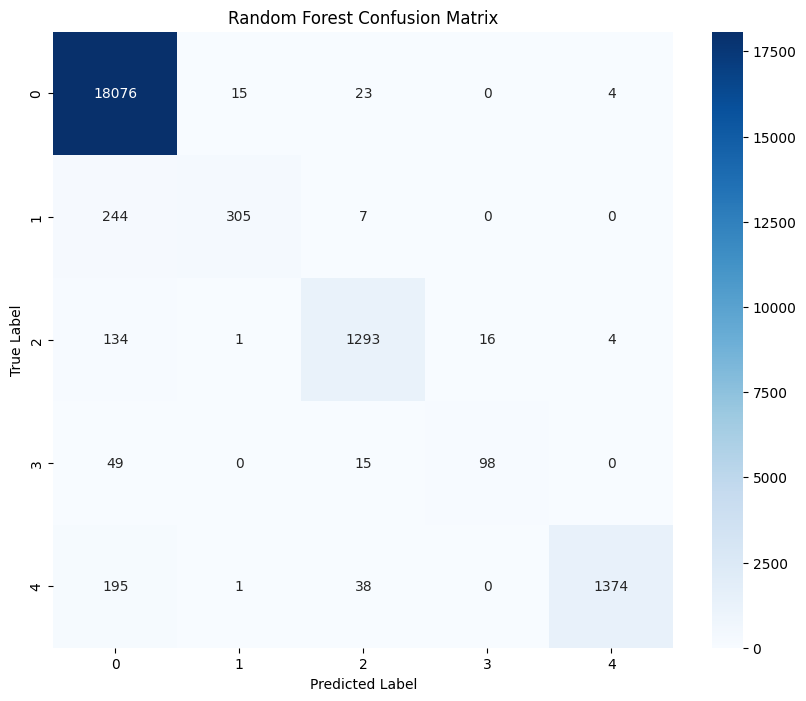

In [29]:
# Plot confusion matrix for Random Forest
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
# Feature importance plot
feature_importances = rf_model.feature_importances_

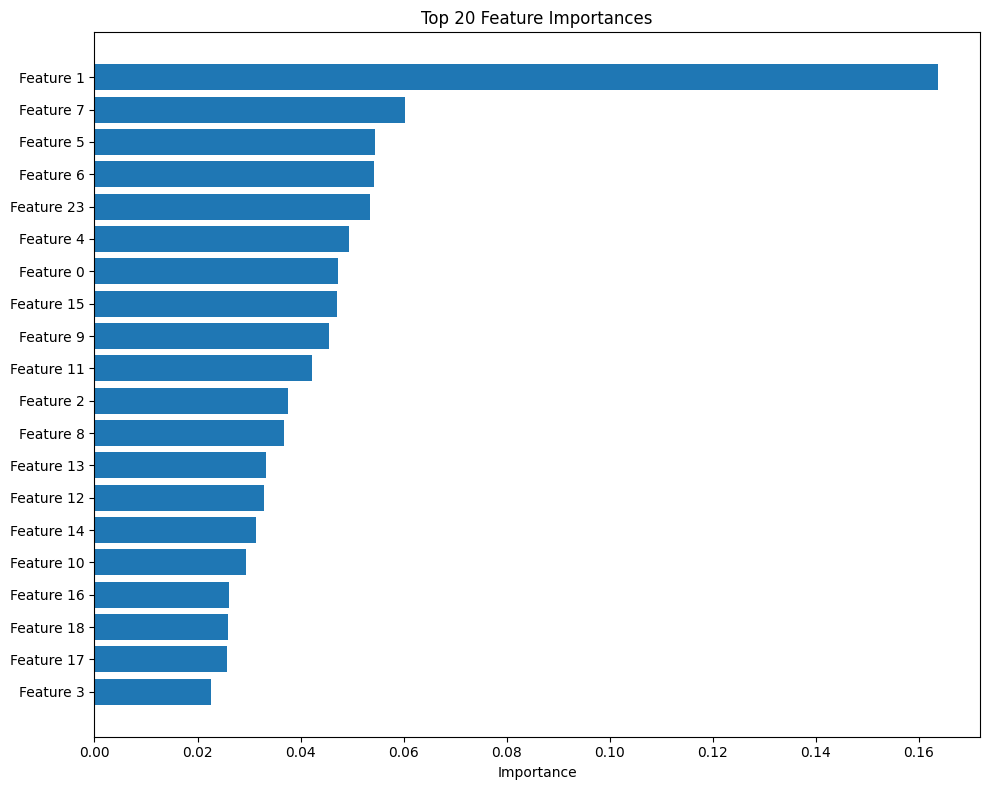

In [31]:
# Plot top 20 features
sorted_idx = np.argsort(feature_importances)[-20:]
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importances[sorted_idx])
plt.yticks(range(20), [f"Feature {i}" for i in sorted_idx])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [32]:
# --- Neural Network Model ---
# Reshape features for CNN input
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [33]:
# Define the model
print("Building and training CNN model...")
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

Building and training CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,566 (291.27 KB)

 Trainable params: 74,566 (291.27 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [37]:
# Train the model
history = model.fit(
    X_train_cnn,
    y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9961 - loss: 0.0343 - val_accuracy: 0.2967 - val_loss: 19.9372
Epoch 2/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 1.0000 - loss: 2.7214e-07 - val_accuracy: 0.2967 - val_loss: 21.6022
Epoch 3/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 5.6863e-08 - val_accuracy: 0.2967 - val_loss: 23.6314
Epoch 4/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 9.1313e-09 - val_accuracy: 0.2967 - val_loss: 25.1111
Epoch 5/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 1.0000 - loss: 2.4425e-09 - val_accuracy: 0.2967 - val_loss: 26.1896
Epoch 6/20
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 8.4133e-10 - val_accuracy: 0.2967 - val_loss: 27.0960


In [38]:
# Evaluate the model
print("Evaluating CNN model...")
loss, accuracy = model.evaluate(X_test_cnn, y_test_encoded)
print(f"CNN Test Accuracy: {accuracy:.4f}")

Evaluating CNN model...
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9837 - loss: 0.4606
CNN Test Accuracy: 0.8276


In [39]:
# CNN predictions
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [40]:
# Classification report for CNN
print("\nCNN Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn_classes))


CNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.83     21892
   macro avg       0.17      0.20      0.18     21892
weighted avg       0.68      0.83      0.75     21892



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


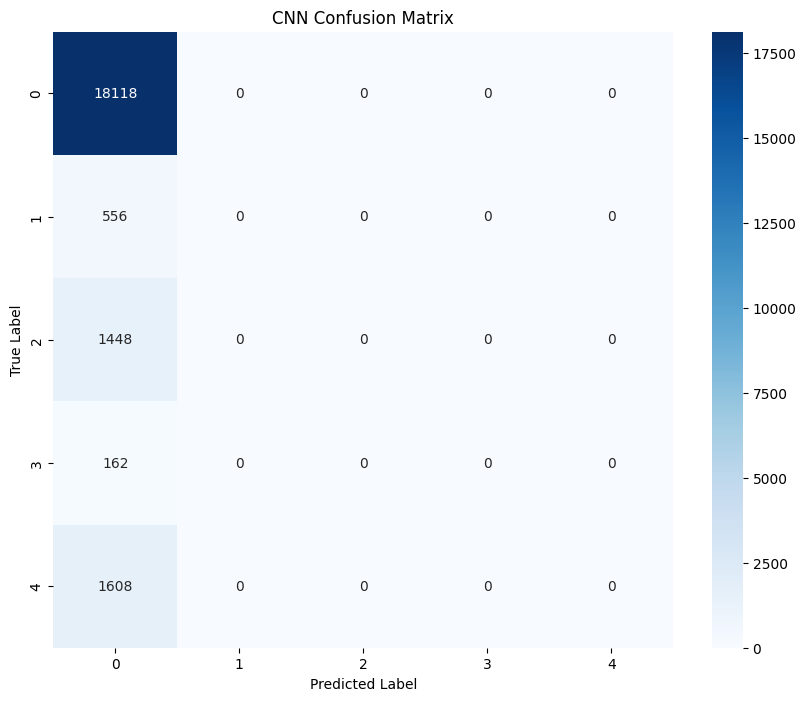

In [41]:
# Plot confusion matrix for CNN
plt.figure(figsize=(10, 8))
cm_cnn = confusion_matrix(y_test_encoded, y_pred_cnn_classes)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
# Plot training history
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

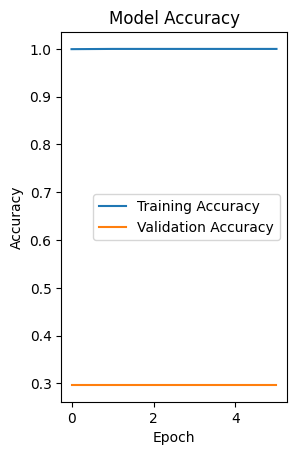

In [43]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

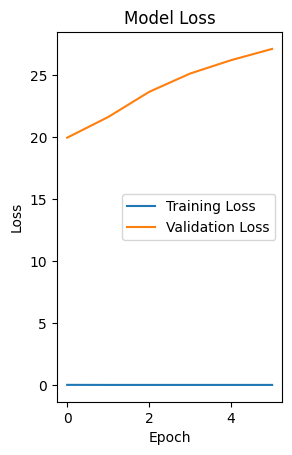

In [44]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [45]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [46]:
# Compare model performances
print("\nModel Performance Comparison:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"CNN Accuracy: {accuracy:.4f}")


Model Performance Comparison:
Random Forest Accuracy: 0.9659
CNN Accuracy: 0.8276


In [47]:
# Class labels for reference
class_names = [
    "Normal beat",
    "Supraventricular premature beat",
    "Premature ventricular contraction",
    "Fusion of ventricular and normal beat",
    "Unclassified beat"
]

In [48]:
# Print class mappings
print("\nClass Labels:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")


Class Labels:
Class 0: Normal beat
Class 1: Supraventricular premature beat
Class 2: Premature ventricular contraction
Class 3: Fusion of ventricular and normal beat
Class 4: Unclassified beat


In [49]:
# Function to predict a single ECG
def predict_ecg(ecg_signal, rf_model, cnn_model, scaler, window_size):
    """
    Predict class for a single ECG signal using both models

    Parameters:
    - ecg_signal: numpy array representing one ECG reading
    - rf_model: trained Random Forest model
    - cnn_model: trained CNN model
    - scaler: fitted StandardScaler
    - window_size: window size for feature extraction

    Returns:
    - predictions from both models
    """
    # Normalize
    max_val = np.max(np.abs(ecg_signal))
    if max_val > 0:
        ecg_normalized = ecg_signal / max_val
    else:
        ecg_normalized = ecg_signal

    # Extract features
    features = extract_features(np.array([ecg_normalized]), window_size)[0]

    # Make sure features match the expected length
    if len(features) < X_train_features.shape[1]:
        features = np.pad(features, (0, X_train_features.shape[1] - len(features)))
    elif len(features) > X_train_features.shape[1]:
        features = features[:X_train_features.shape[1]]

    # Reshape features for models
    features_scaled = scaler.transform([features])[0]

    # Random Forest prediction
    rf_pred = rf_model.predict([features_scaled])[0]
    rf_prob = np.max(rf_model.predict_proba([features_scaled]))

    # CNN prediction
    cnn_input = features_scaled.reshape(1, len(features_scaled), 1)
    cnn_pred_prob = cnn_model.predict(cnn_input)[0]
    cnn_pred = np.argmax(cnn_pred_prob)
    cnn_prob = cnn_pred_prob[cnn_pred]

    return {
        'rf_prediction': rf_pred,
        'rf_probability': rf_prob,
        'cnn_prediction': cnn_pred,
        'cnn_probability': cnn_prob
    }

# Example: Predict a random test sample
sample_idx = np.random.randint(0, len(X_test_raw))
sample = X_test_raw[sample_idx]
true_class = y_test[sample_idx]

prediction_results = predict_ecg(sample, rf_model, model, scaler, window_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


In [50]:
# Example: Predict a random test sample
sample_idx = np.random.randint(0, len(X_test_raw))
sample = X_test_raw[sample_idx]
true_class = y_test[sample_idx]

prediction_results = predict_ecg(sample, rf_model, model, scaler, window_size)

print(f"\nSample prediction:")
print(f"True class: {true_class} ({class_names[int(true_class)]})")
print(f"Random Forest prediction: {prediction_results['rf_prediction']} ({class_names[prediction_results['rf_prediction']]})")
print(f"Random Forest probability: {prediction_results['rf_probability']:.4f}")
print(f"CNN prediction: {prediction_results['cnn_prediction']} ({class_names[prediction_results['cnn_prediction']]})")
print(f"CNN probability: {prediction_results['cnn_probability']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Sample prediction:
True class: 0.0 (Normal beat)
Random Forest prediction: 0 (Normal beat)
Random Forest probability: 0.9800
CNN prediction: 0 (Normal beat)
CNN probability: 1.0000


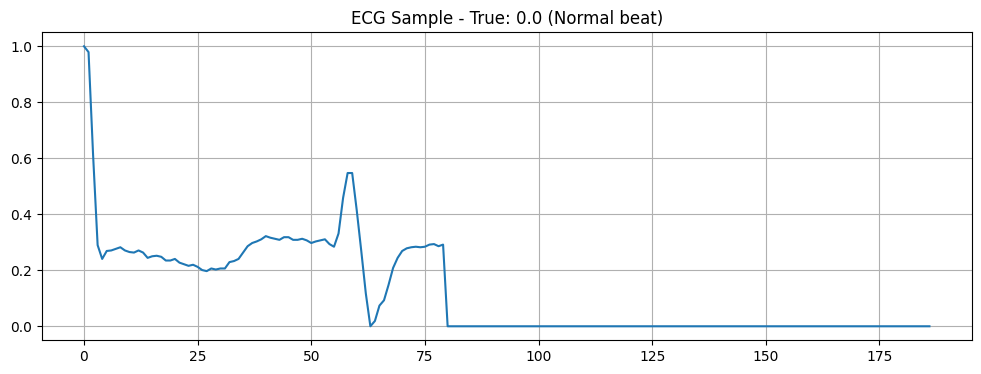

ECG classification system complete!


In [51]:
# Plot the sample
plt.figure(figsize=(12, 4))
plt.plot(sample)
plt.title(f"ECG Sample - True: {true_class} ({class_names[int(true_class)]})")
plt.grid(True)
plt.show()

print("ECG classification system complete!")